# 01. Learning LangGraph - Agent Executor

In [33]:
# !pip install --quiet -U langchain langchain_openai langgraph langchainhub langchain_experimental
# !pip install PyPDF2

modified from https://github.com/langchain-ai/langgraph/blob/main/examples/agent_executor/base.ipynb

In [1]:
import os
from dotenv import load_dotenv  # Importing dotenv to load environment variables from a .env file
import openai
load_dotenv()  # Load environment variables from .env file

os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
os.environ["ENDPOINT"] = os.getenv('ENDPOINT')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_API_KEY"] = os.getenv('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = "LangGraph_01"

## Making the GraphState

In [2]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator

class AgentState(TypedDict):
   # The input string
   input: str
   # The list of previous messages in the conversation
   chat_history: list[BaseMessage]
   # The outcome of a given call to the agent
   # Needs `None` as a valid type, since this is what this will start as
   agent_outcome: Union[AgentAction, AgentFinish, None]
   # List of actions and corresponding observations
   # Here we annotate this with `operator.add` to indicate that operations to
   # this state should be ADDED to the existing values (not overwrite it)
   intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

## Custom Tools

**Tools**  

Tools are interfaces that an agent can use to interact with the world. They combine a few things:



1.   The name of the tool
2.   A description of what the tool is
3.   JSON schema of what the inputs to the tool are
4.   The function to call


Whether the result of a tool should be returned directly to the user

In [5]:
assistant = AssistantAgent(
    name="assistant",
    system_message="You are a helpful assistant.",
    llm_config={
        "timeout": 600,
        "cache_seed": 42,
        "config_list": config_list,
    },
)
ragproxyagent = RetrieveUserProxyAgent(
    name="ragproxyagent",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=3,
    retrieve_config={
        "task": "code",
        "docs_path": [
            "https://raw.githubusercontent.com/microsoft/FLAML/main/website/docs/Examples/Integrate%20-%20Spark.md",
            "https://raw.githubusercontent.com/microsoft/FLAML/main/website/docs/Research.md",
            os.path.join(os.path.abspath(""), "..", "website", "docs"),
        ],
        "custom_text_types": ["mdx"],
        "chunk_token_size": 2000,
        "model": config_list[0]["model"],
        "client": chromadb.PersistentClient(path="/tmp/chromadb"),
        "embedding_model": "all-mpnet-base-v2",
        "get_or_create": True,  # set to False if you don't want to reuse an existing collection, but you'll need to remove the collection manually
    },
    code_execution_config=False,  # set to False if you don't want to execute the code
)

NameError: name 'AssistantAgent' is not defined

In [9]:
import random
import os
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.models import VectorizedQuery
import openai
from langchain.tools import BaseTool, StructuredTool, Tool, tool
import logging

@tool("lower_case", return_direct=True)
def to_lower_case(input:str) -> str:
  """Returns the input as all lower case."""
  return input.lower()

@tool("random_number", return_direct=True)
def random_number_maker(input:str) -> str:
    """Returns a random number between 0-100."""
    return random.randint(0, 100)

@tool("search_similar_documents", return_direct=True)
def search_similar_documents(user_query: str):
    """
    Get embeddings for the user query and search for similar documents in Azure Search.

    Args:
        user_query (str): The input query to search for similar documents.

    Returns:
        None: Prints the search results directly.
    """
    # Load Azure Search service configuration from environment variables
    service_endpoint = os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"]
    index_name = os.environ["AZURE_SEARCH_INDEX_NAME"]
    key = os.environ["AZURE_SEARCH_API_KEY"]
    k_nearest_neighbors = 3  # Number of nearest neighbors to retrieve

    # Load OpenAI configuration from environment variables
    open_ai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
    open_ai_key = os.getenv("AZURE_OPENAI_API_KEY")

    # Initialize OpenAI client
    openai_client = openai.AzureOpenAI(
        azure_endpoint=open_ai_endpoint,
        api_key=open_ai_key,
        api_version="2023-03-15-preview",
    )

    # Get embeddings for the user query
    embedding = openai_client.embeddings.create(input=[user_query], model="text-embedding-ada-002")
    query_vector = embedding.data[0].embedding

    # Initialize the Azure Search client
    search_client = SearchClient(service_endpoint, index_name, AzureKeyCredential(key))

    # Create a vectorized query
    vector_query = VectorizedQuery(
        vector=query_vector,
        k_nearest_neighbors=k_nearest_neighbors,
        fields="chunkVector",
    )

    # Execute the hybrid search
    results = search_client.search(
        search_text= "Payroll Summary",
        vector_queries=[vector_query],
        select=["chunkId", "parentDoc", "chunk"],
    )

    # Print the results
    print("Search Results:")
    for result in results:
        print(f"Chunk ID: {result['chunkId']}, Parent Document: {result['parentDoc']}, Chunk: {result['chunk']}")

tools = [to_lower_case,random_number_maker,search_similar_documents]

In [26]:
random_number_maker.run('random')

22

In [12]:
search_similar_documents.run("chunk")

Search Results:


ResourceNotFoundError: () The index 'socr-test-idx' for service 'uscdadvecnazs01' was not found.
Code: 
Message: The index 'socr-test-idx' for service 'uscdadvecnazs01' was not found.

In [11]:
to_lower_case.run('SAM')

'sam'

## Agent - with new create_open_ai

In [9]:
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain_openai import AzureChatOpenAI 

# Get the prompt to use - you can modify this!
prompt = hub.pull("hwchase17/openai-functions-agent")

# Choose the LLM that will drive the agent
llm = AzureChatOpenAI(model="gpt-4o",azure_endpoint = os.getenv('ENDPOINT') , streaming=True)

# Construct the OpenAI Functions agent
agent_runnable = create_openai_functions_agent(llm,
                                               tools,
                                               prompt)

In [13]:
prompt

ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], optional_variables=['chat_history'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='

In [30]:
prompt.get_prompts()

[ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], optional_variables=['chat_history'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag=

In [10]:
inputs = {"input": "give me a random number and then write in words and make it lower case.",
          "chat_history": [],
          "intermediate_steps":[]}

agent_outcome = agent_runnable.invoke(inputs)

In [29]:
agent_outcome

AgentActionMessageLog(tool='random_number', tool_input={'input': 'give random number'}, log="\nInvoking: `random_number` with `{'input': 'give random number'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"give random number"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_04751d0b65'}, id='run-00668c33-05ca-4ebd-866d-137d3087fa87-0')])

In [28]:
type(agent_runnable)

langchain_core.runnables.base.RunnableSequence

## Nodes

In [11]:
from langchain_core.agents import AgentFinish
from langgraph.prebuilt.tool_executor import ToolExecutor

tool_executor = ToolExecutor(tools)

C:\Users\TH967NM\AppData\Local\Temp\ipykernel_13292\2882498864.py:4: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


In [12]:
# Define the agent/graph
def run_agent(data):
    agent_outcome = agent_runnable.invoke(data)
    return {"agent_outcome": agent_outcome}

# Define the function to execute tools
def execute_tools(data):
    # Get the most recent agent_outcome - this is the key added in the `agent` above
    agent_action = data['agent_outcome']
    # Execute the tool
    output = tool_executor.invoke(agent_action)
    print(f"The agent action is {agent_action}")
    print(f"The tool result is: {output}")
    # Return the output
    return {"intermediate_steps": [(agent_action, str(output))]}

# Define logic that will be used to determine which conditional edge to go down
def should_continue(data):
    # If the agent outcome is an AgentFinish, then we return `exit` string
    # This will be used when setting up the graph to define the flow
    if isinstance(data['agent_outcome'], AgentFinish):
        return "end"
    # Otherwise, an AgentAction is returned
    # Here we return `continue` string
    # This will be used when setting up the graph to define the flow
    else:
        return "continue"

## Define the graph

In [13]:
from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", run_agent)
workflow.add_node("action", execute_tools)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END
    }
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge('action', 'agent')

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

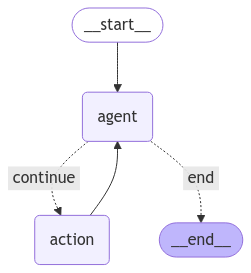

In [14]:
app

In [15]:
workflow.branches

defaultdict(dict,
            {'agent': {'should_continue': Branch(path=should_continue(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), ends={'continue': 'action', 'end': '__end__'}, then=None)}})

In [16]:
workflow.nodes , workflow.edges

({'agent': StateNodeSpec(runnable=agent(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None, input=<class '__main__.AgentState'>, retry_policy=None, ends=()),
  'action': StateNodeSpec(runnable=action(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None, input=<class '__main__.AgentState'>, retry_policy=None, ends=())},
 {('__start__', 'agent'), ('action', 'agent')})

In [17]:
workflow.channels #['intermediate_steps']

{'input': <langgraph.channels.last_value.LastValue at 0x1f154ccd4c0>,
 'chat_history': <langgraph.channels.last_value.LastValue at 0x1f15491db40>,
 'agent_outcome': <langgraph.channels.last_value.LastValue at 0x1f154ccde80>,
 'intermediate_steps': <langgraph.channels.binop.BinaryOperatorAggregate at 0x1f154ccd780>}

In [22]:
inputs = {"input": "give me a random number and then write in words and make it lower case.", "chat_history": []}
for s in app.stream(inputs): 
    print(list(s.values())[0])
    print("----")

dict_values([{'agent_outcome': AgentActionMessageLog(tool='random_number', tool_input={'input': 'give me a random number'}, log="\nInvoking: `random_number` with `{'input': 'give me a random number'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"give me a random number"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_04751d0b65'}, id='run-bfc6c5dc-9c00-47a7-8665-8fb1cae77f2d-0')])}])
----
The agent action is tool='random_number' tool_input={'input': 'give me a random number'} log="\nInvoking: `random_number` with `{'input': 'give me a random number'}`\n\n\n" message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"give me a random number"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_04751d0b65'}, i

In [23]:
inputs = {"input": "give me a random number and then write in words and make it lower case", "chat_history": []}

output = app.invoke(inputs)

The agent action is tool='random_number' tool_input={'input': 'random'} log="\nInvoking: `random_number` with `{'input': 'random'}`\n\n\n" message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"random"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_04751d0b65'}, id='run-9dcafe09-7715-4324-a042-fbeed792a86f-0')]
The tool result is: 60


In [24]:
output.get("agent_outcome").return_values['output']

'The random number is sixty.'

In [25]:
output.get("intermediate_steps")

[(AgentActionMessageLog(tool='random_number', tool_input={'input': 'random'}, log="\nInvoking: `random_number` with `{'input': 'random'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"random"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_04751d0b65'}, id='run-9dcafe09-7715-4324-a042-fbeed792a86f-0')]),
  '60')]

In [26]:
inputs = {"input": "does it get cold in SF in Jan?", "chat_history": []}
output = app.invoke(inputs)

In [36]:
output.get("agent_outcome").return_values['output']

"Yes, it can get cold in San Francisco in January. While San Francisco generally has a mild climate, January is one of the colder months. Average temperatures typically range from the mid-40s to the mid-50s Fahrenheit (around 7-13 degrees Celsius). It can be quite chilly, especially with the wind and dampness, so it's a good idea to dress warmly if you're visiting during this time."

In [27]:
output.get("intermediate_steps")

[]